# Project 4 - QR Code Reader

### What to Submit
Submit this iPython Notebook--containing all your code for the programming exercises below--on [learning suite](https://learningsuite.byu.edu/).

Your notebook file should produce the relevant plots and also provide a short write-up with answers to the questions below.

Please also fill in here the time that each part took you:
* 1. Part A: <span style="color:red;">1.5hrs</span>
* 2. Part B: <span style="color:red;">1.5hrs</span>
* 3. Part C: <span style="color:red;">1hr</span>
* 4. Tests: <span style="color:red;">10 mins</span>
* 5. Challenge 1: <span style="color:red;">1 min</span>
* 6. Challenge 2: <span style="color:red;">30 min</span>
* 7. Write-up: <span style="color:red;">FILL IN TIME</span>

### Understanding QR Codes

QR codes (short for Quick Response Codes) were invented in 1994, by the DENSO Corporation. These codes store data in two dimensions in the form of an array of contrasting regions. The information density of a QR code is much higher than a vanilla barcode; depending on the format used and the resolution of reader, over a thousand bytes can be encoded in a region the size of a postage stamp.

QR codes use a Reed–Solomon error correction based technology to help recover from errors in reading (for instance, caused by a smudge, badly printed code or other deformity).

Any QR code can be broken into the following sections:

<div style="width:75%;text-align:center;"><img src="Images/formatting.jpg" width=100%></div>

On three corners of a QR code are square blocks that the reader uses to coarsely identify and then align the code. These will be of primary interest during the lab. Once these corners are identified and the image is aligned, the size of the QR code is determined by the timing information which alternates from black and white in both the vertical and horizontal direction. 

Once the image is aligned and the size determined, the QR code is discretized, undergoes an Xor with a particular mask given the format information, and read bit for bit in the following order:

<div style="width:75%;text-align:center;"><img src="Images/decoding.jpg" width=100%></div>

For more details about the decoding process, see the [DataGenetics Wounded QR Codes Blog](http://datagenetics.com/blog/november12013/index.html).

For this lab, we will focus primarily the computer vision side of QR codes, which involves detecting, aligning, and discretizing QR codes so that they can be read properly.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

### Part A: Finding Corners

QR codes are designed with a very specific pattern so that can efficiently be detected, oriented, and decoded. The first step to detecting a QR code is finding the position markers that are always present in three of the four corners. These position markers always have a black/white/black/white/black ratio of 1:1:3:1:1, no matter the angle they are approached from.

<div style="width:20%;text-align:center;"><img src="Images/finder_pattern.jpg" width=100%></div>

Preprocess your image by thresholding to black and white. Scan across rows of the image, marking locations that have the 1:1:3:1:1 ratio (note: this is most easily done by keeping multiple counters for black and white pixels).

<div style="width:20%;text-align:center;"><img src="Images/first_scan.jpg" width=100%></div>

Once you have candidate locations, verify the locations by also scanning vertically, diagonally and in other directions. Also complete a non maximal suppression to get your final three candidate points.

<div style="width:20%;text-align:center;"><img src="Images/candidates.JPG" width=100%></div>

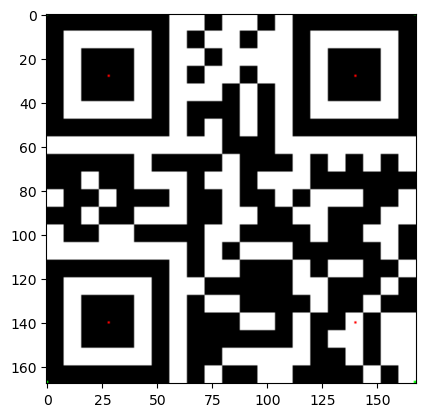

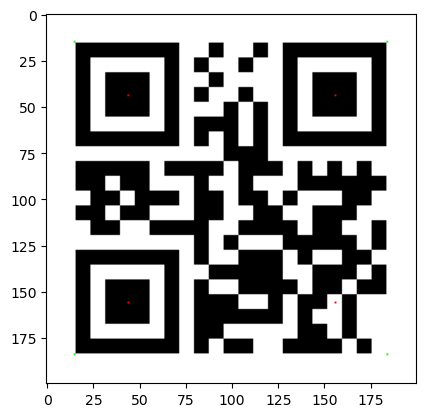

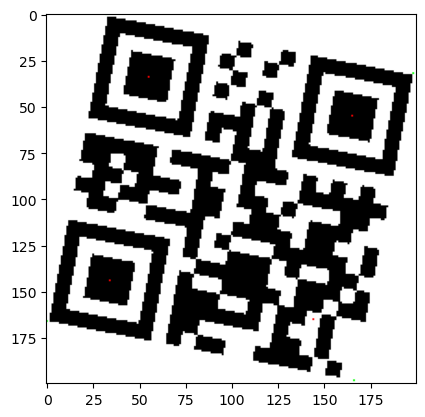

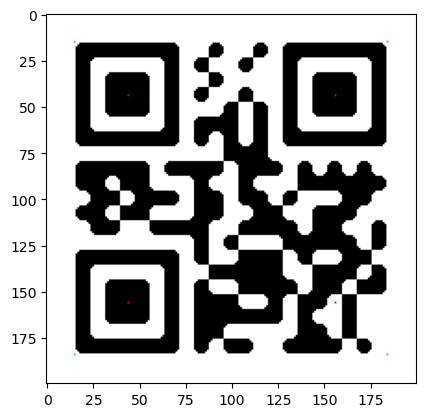

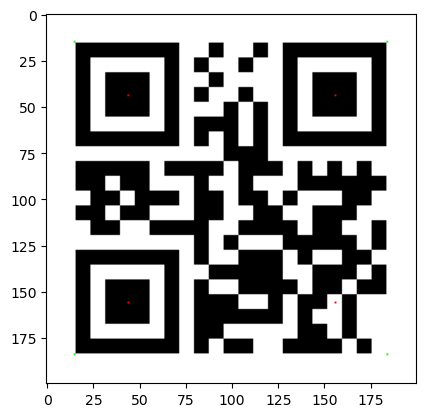

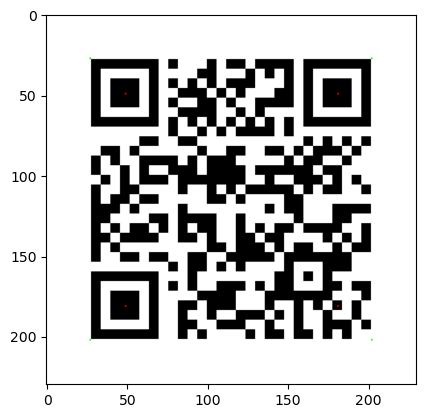

Success!


In [2]:
#Your Code Here
def findDistance(p1,p2):
    return np.sqrt((p1[0]-p2[0])**2 + (p1[1] - p2[1])**2)

def valid(r1, r2, e=1):
    if r2 - e < r1 and r1 < r2 + e:
        return True
    return False

def checkRatio(r, i, e=1):
    if i+4 >= len(r):
        return False
    if not r[i][0] >= r[i+1][0] - e or not r[i][0] <= r[i+1][0] + e:
        return False
    if not 3*r[i][0] >= r[i+2][0] - e or not 3*r[i][0] <= r[i+2][0] + e:
        return False
    if not r[i][0] >= r[i+3][0] - e or not r[i][0] <= r[i+3][0] + e:
        return False
    if not r[i][0] >= r[i+4][0] - e or not r[i][0] <= r[i+4][0] + e:
        return False
    return True


def findPoints(imgName, draw=False):
    img = cv2.imread(imgName)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    gray[gray<=127] = 0
    gray[gray>127] = 255
    img[gray<=127] = [0,0,0]
    img[gray>127] = [255,255,255]

    #Horizontal
    allCounters = []
    for r in range (img.shape[0]):
        levelCounter = []
        currRun = [(r,0)]
        lastVal = gray[r,0]
        for c in range(1, img.shape[1]):
            currVal = gray[r,c]
            if currVal == lastVal:
                currRun.append((r,c))
            else:
                lastVal = gray[r,c]
                levelCounter.append((len(currRun), currRun))
                currRun = [(r,c)]
        levelCounter.append((len(currRun), currRun))
        allCounters += [levelCounter]



    accum = np.zeros(gray.shape)
    scaleMap = {}
    for i in range(len(allCounters)):
        r = allCounters[i]
        for j in range(len(r)):
            c = r[j]
            if gray[c[1][0]] == 255:
                continue
            if checkRatio(r, j):
                tmp = r[j+2][1]
                accum[tmp[len(tmp)//2]] += 1
                scaleMap[tmp[len(tmp)//2]] = c[0]

    #Vertical
    allCounters = []
    for c in range (img.shape[1]):
        levelCounter = []
        currRun = [(0,c)]
        lastVal = gray[0,c]
        for r in range(1, img.shape[0]):
            currVal = gray[r,c]
            if currVal == lastVal:
                currRun.append((r,c))
            else:
                lastVal = gray[r,c]
                levelCounter.append((len(currRun), currRun))
                currRun = [(r,c)]
        levelCounter.append((len(currRun), currRun))
        allCounters += [levelCounter]


    for i in range(len(allCounters)):
        r = allCounters[i]
        for j in range(len(r)):
            c = r[j]
            if gray[c[1][0]] == 255:
                continue
            if checkRatio(r, j):
                tmp = r[j+2][1]
                accum[tmp[len(tmp)//2]] += 1
                scaleMap[tmp[len(tmp)//2]] = c[0]

    #gets the 3 points in the image with the most votes
    points = []
    for i in range(3):
        maxVal = np.argmax(accum)
        maxVal = np.unravel_index(maxVal, accum.shape)
        points.append(np.array((maxVal[0], maxVal[1]), dtype=int))
        img[maxVal] = [255,0,0]
        accum[maxVal[0]-10:maxVal[0]+10, maxVal[1]-10:maxVal[1]+10] = 0

    #finds which point is the center
    center = 0
    nonCenter = (1,2)
    cVal = max(np.linalg.norm(points[1] - points[0]), np.linalg.norm(points[2]-points[0]))
    tmp = max(np.linalg.norm(points[0]-points[1]), np.linalg.norm(points[2] - points[1]))
    if cVal > tmp:
        center = 1
        nonCenter = (0,2)
        cVal = tmp
    tmp = max(np.linalg.norm(points[0]-points[2]), np.linalg.norm(points[1] - points[2]))
    if cVal > tmp:
        center = 2
        nonCenter = (0,1)


    #finds the orientation of the other 2 points with respect to the center(needed for challenge1)
    if points[nonCenter[0]][1] - points[center][1] < points[nonCenter[1]][1] - points[center][1]:
        lPoint = nonCenter[0]
        rPoint = nonCenter[1]
    else:
        lPoint = nonCenter[1]
        rPoint = nonCenter[0]

    nonCenter = (rPoint, lPoint)

    #finds the forth point
    diff = points[nonCenter[0]] - points[center]
    points.append(points[nonCenter[1]] + diff)
    img[points[3][0], points[3][1]] = [255,0,0]

    #finds the corners using the formula P = Porigin + Pdirection*T*scale
    #I'm using a T value as 5 to account for the diagonal which I found worked well on all imgs
    cornerPoints = []
    newPoints = []
    scale = scaleMap[points[center][0], points[center][1]]
    ori = points[center]
    cornerDir = (points[center] - points[3]) / np.linalg.norm(points[center]-points[3])
    cornerPoints.append((ori + cornerDir*5*scale).astype(int))
    newPoints.append(points[center])

    ori = points[3]
    cornerDir *= -1
    cornerPoints.append((ori + cornerDir*5*scale).astype(int))
    newPoints.append(points[3])

    ori = points[nonCenter[0]]
    cornerDir = (points[nonCenter[0]] - points[nonCenter[1]]) / np.linalg.norm(points[nonCenter[0]]-points[nonCenter[1]])
    cornerPoints.append((ori + cornerDir*5*scale).astype(int))
    newPoints.append(points[nonCenter[0]])

    ori = points[nonCenter[1]]
    cornerDir *= -1
    cornerPoints.append((ori + cornerDir*5*scale).astype(int))
    newPoints.append(points[nonCenter[1]])

    for p in cornerPoints:
        p = np.clip(p,0,img.shape[0]-1)
        img[p[0], p[1]] = [0,255,0]

    roughSize = int(np.linalg.norm(cornerPoints[0] - cornerPoints[2]))

    if(draw):
        plt.imshow(img, cmap='gray');plt.show()

    return np.array(cornerPoints), np.array(newPoints),  roughSize, gray

findPoints("QR_codes/Basic.png", True)
findPoints("QR_codes/test1.png", True)
findPoints("QR_codes/test2.png", True)
findPoints("QR_codes/test3.png", True)
findPoints("QR_codes/test4.png", True)
findPoints("QR_codes/test5.png", True)
print("Success!")

### Part B: Finding The Fourth Point and Aligning with a Homography

QR codes only contain three known corner points, but homographies require four points to be defined. If the warping present in the image is small enough, an affine transform is generally sufficient to find the fourth point (i.e. the *x,y* coordinate difference between point 1 and point 2 will be the same as the *x,y* coordinate difference between point 3 and point 4). Use this assumption to find the fourth point.

<div style="width:20%;text-align:center;"><img src="Images/four_points.JPG" width=100%></div>

Once you have the four points, generate the homography that would align the QR code with the *x,y* axes. Crop the aligned image until only the QR code is visible.

<div style="width:20%;text-align:center;"><img src="Images/aligned.jpg" width=100%></div>

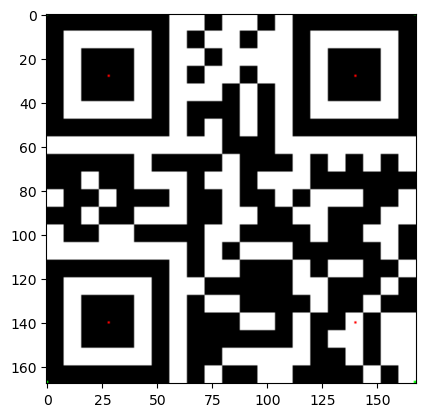

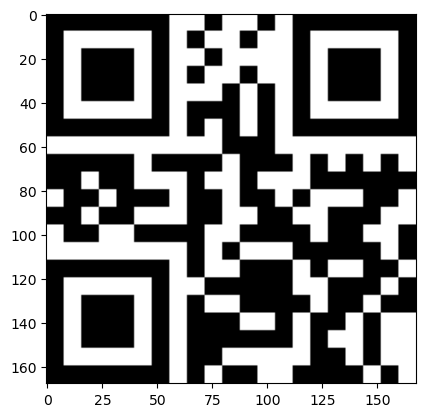

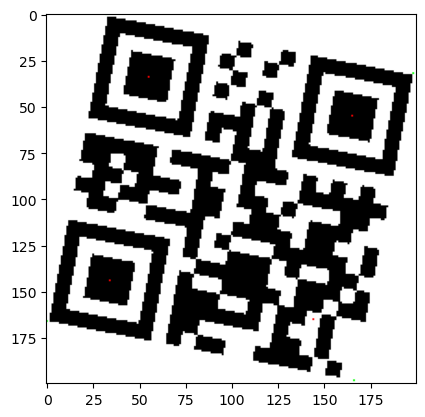

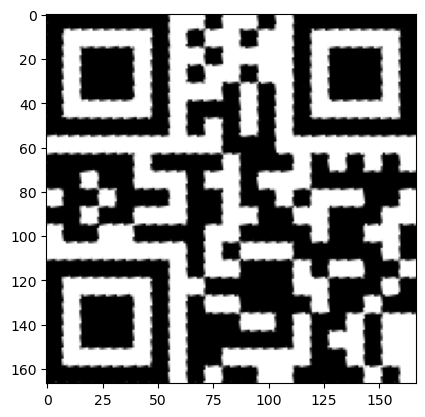

Success!


In [3]:
# Your Code Here
# Can use find homography
def reversePoints(points):
    newPoints = []
    for p in points:
        newPoints.append(p[::-1])
    return np.array(newPoints)

def cropImg(img):
    diff = 0
    while not img[10, 0] == 0:
        img = img[:, 1:]
        diff += 1
    img = img[diff:, :]

    diff = 0
    while not img[10, -1] == 0:
        img = img[:, :-1]
        diff += 1
    img = img[:img.shape[0]-diff, :]
    return img


def getAlignedImg(imgName, draw=False):
    cPoints, points, size, img = findPoints(imgName, draw)
    cPoints = reversePoints(cPoints)
    dest = np.array([[0,0], [size, size], [0,size], [size,0]])
    H, _ = cv2.findHomography(cPoints, dest)

    #align and clean up image
    result = cv2.warpPerspective(img, H, (size, size))
    result = np.transpose(result)
    result = cropImg(result)

    if draw:
        plt.imshow(result, cmap='gray');plt.show()

    return result

getAlignedImg("QR_codes/Basic.png", True)
getAlignedImg("QR_codes/test2.png", True)
print("Success!")

### Part C: Discretization

Now that the image is aligned, the QR code needs to discretized so that each block is a single bit, rather than a group of pixels. The simplest way to do this is to count the number of black and white pixels in a region and assign the block to the highest count. However, to do this, the size of the QR code needs to be determined. All QR codes have an odd number of bits per row and column, starting at size 21 and incrementing by 4 (i.e. 21x21, 25x25, 29x29, ...). For this lab, you will only need to check for sizes from 21 to 33.

To check if a QR code matches a given size, discretize the QR code asumming the given size. Then, determine if the timing information alternates in the appropriate manner (see the Understanding QR Codes for more information). If the timing information is valid, then you can assume that the QR code is the given size.

Once you have the correct size, discretize the QR code accordingly and return a Numpy array of True/False values.


In [4]:
# Your Code Here
def checkSize(size, img):
    bitSize = round(img.shape[0]/size)

    #loops over timing info based of images size and ensures it alternates
    r = 6*bitSize
    isBlack = True
    for i in range(size - 14):
        c = i*bitSize + 7*bitSize
        avg = np.average(img[r:r+bitSize, c:c+bitSize])
        #if the average of the bit area is greater than 127 then there are more white pixels then black
        if avg > 127:
            if not isBlack: return False
            isBlack = False
        else:
            if  isBlack: return False
            isBlack = True

    return True

def getArray(imgName, draw=False):
    img = getAlignedImg(imgName, draw)
    size = 0

    #checks each possible size
    if checkSize(21, img): size = 21
    elif checkSize(25, img): size = 25
    elif checkSize(29, img): size = 29
    elif checkSize(33, img): size = 33
    else:
        print("Could not find valid size")
        exit(1)

    dArray = np.zeros((size, size), dtype=bool)
    bitSize = round(img.shape[0]/size)

    i = 0
    for r in range(0, img.shape[0], bitSize):
        j = 0
        for c in range(0, img.shape[1], bitSize):
            avg = np.average(img[r:r+bitSize, c:c+bitSize])
            if avg > 127:
                dArray[i,j] = True
            else:
                dArray[i,j] = False
            j+=1
        i+=1
    return dArray

### Part D: Decoding

QR codes are decoded using a very particular block pattern (see Understanding QR Codes). However, for simplicity, we have implemented this decoder for you. To use it, simply call `decode()` from the decoder.py file and feed it your 2D Numpy array. It will return a string with the QR code data.

**Note: You may need to run** `conda install beautifulsoup4` **and** `conda install requests` **to get the decoder to run.**

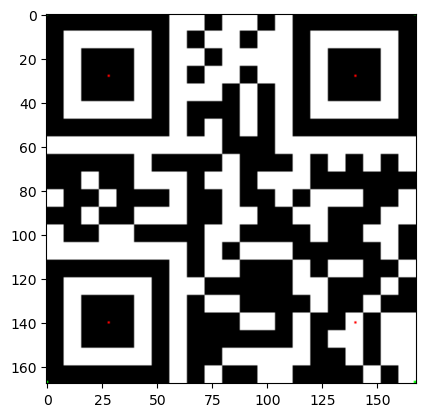

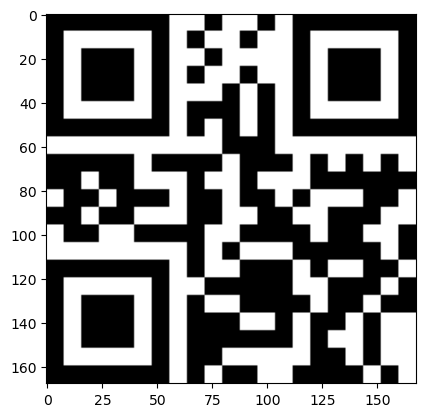

http://byu.edu


In [5]:
from decoder import decode
your_array = getArray("QR_codes/Basic.png", True)
output = decode(your_array)
print(output)

## Tests

Once you have your full algorithm working, run your code on the five test images in the *QR_codes* folder. Show your results below.

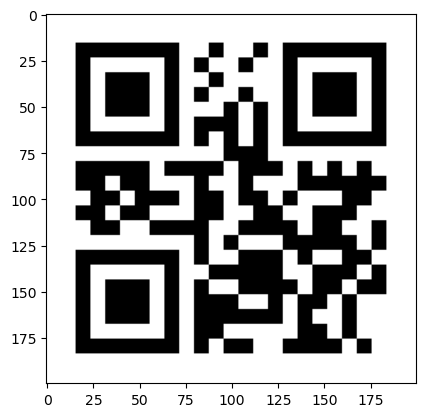

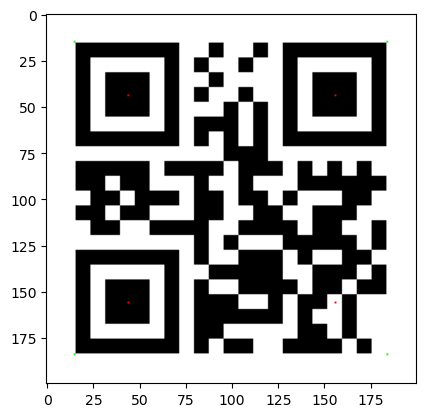

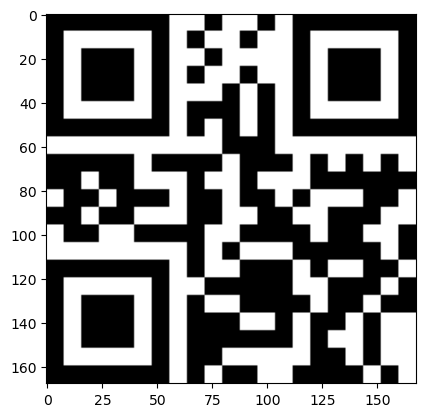

http://byu.edu


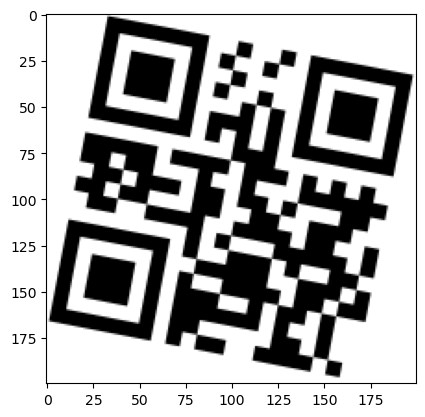

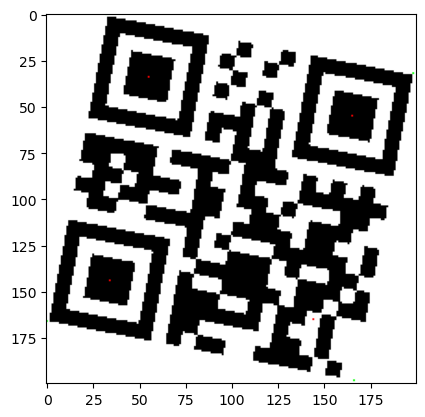

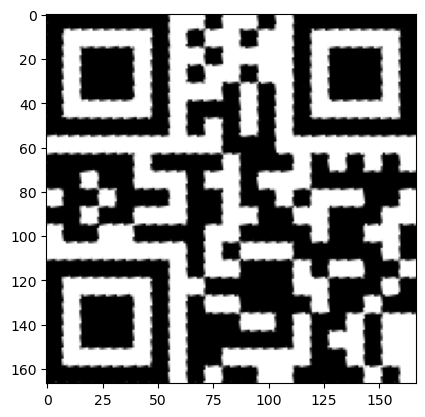

http://byu.edu


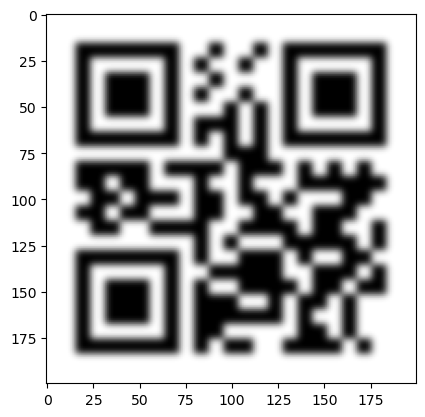

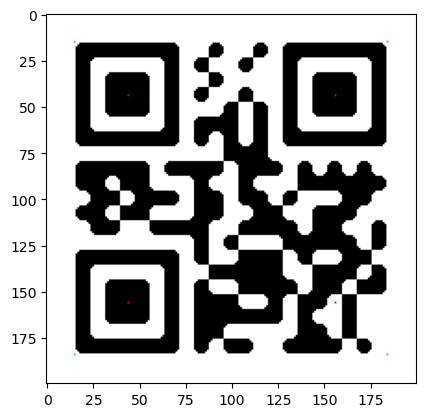

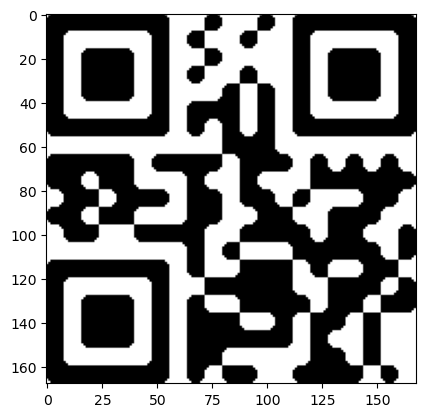

http://byu.edu


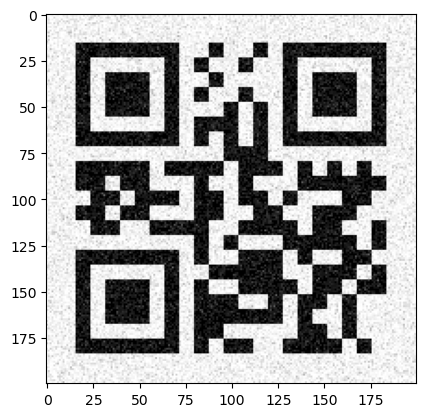

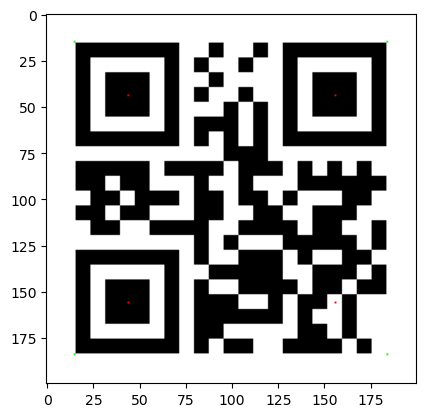

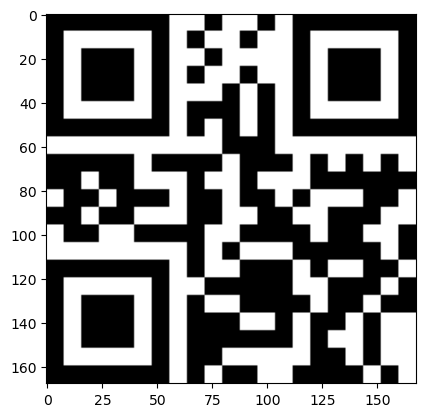

http://byu.edu


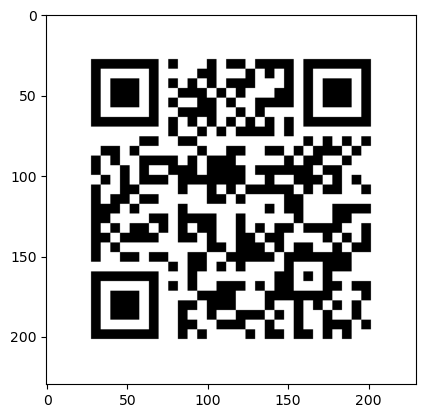

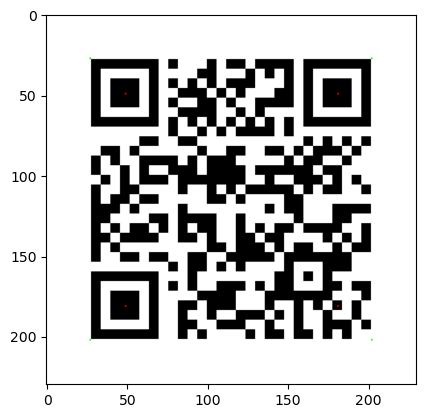

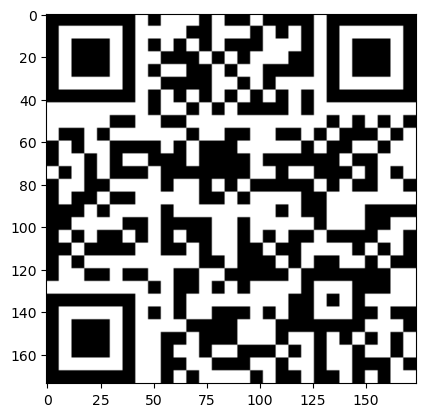

http://DataGenetics.com


In [6]:
image = cv2.imread("QR_codes/test1.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(image,cmap="gray");plt.show()
dArray = getArray("QR_codes/test1.png", True)
output = decode(dArray)
print(output)


image = cv2.imread("QR_codes/test2.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(image,cmap="gray");plt.show()
dArray = getArray("QR_codes/test2.png", True)
output = decode(dArray)
print(output)

image = cv2.imread("QR_codes/test3.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(image,cmap="gray");plt.show()
dArray = getArray("QR_codes/test3.png", True)
output = decode(dArray)
print(output)

image = cv2.imread("QR_codes/test4.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(image,cmap="gray");plt.show()
dArray = getArray("QR_codes/test4.png", True)
output = decode(dArray)
print(output)

image = cv2.imread("QR_codes/test5.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(image,cmap="gray");plt.show()
dArray = getArray("QR_codes/test5.png", True)
output = decode(dArray)
print(output)


## Grading and Challenges
Points for this assigment will be assigned as follows (100 points total):
* [20 pts] Code that correctly finds the three corners of the QR code.
* [20 pts] Code that aligns the QR code and crops appropriately.
* [20 pts] Code that correctly discretizes for an arbitrary size.
* [10 pts] For a full algorithm that correctly scans the five test images.

The last 30 points are earned through completing a subset of the following challenges:

* [15 pts] Correctly scan a QR code that is misaligned by more than 90 degrees (e.g. challenge1.png)
* [15 pts] Correctly scan a QR code that is perspective shifted by using the additional alignment square present in larger QR codes. (e.g. challenge2.png)
* [15 pts] Correctly scan a QR code that is surrounded by additional pixels (e.g. challenge3.png)
* [15 pts] Correctly scan a QR code with large amounts of noise and distortion (e.g. challenge4.png)
* [30 pts] Implement a Code 128 1D bar code scanner (e.g. challenge5.png)

You may earn up to 15 points extra credit for additional challenges you complete.



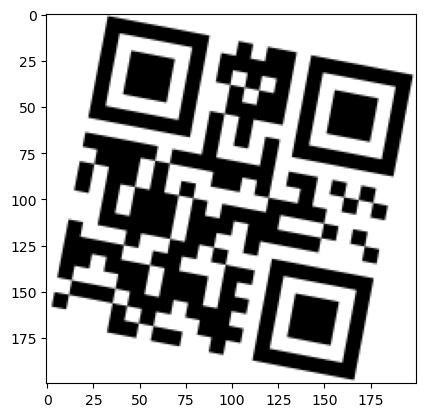

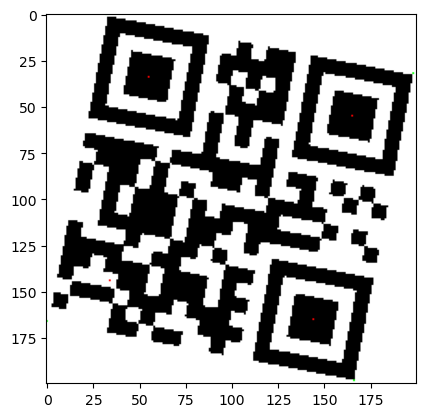

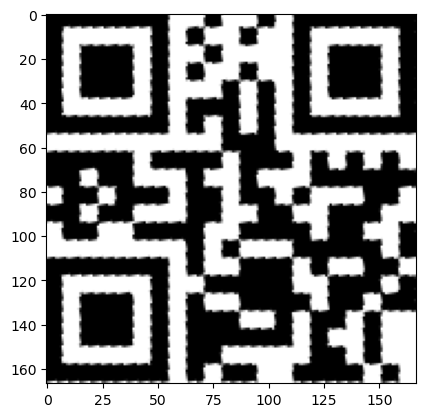

http://byu.edu


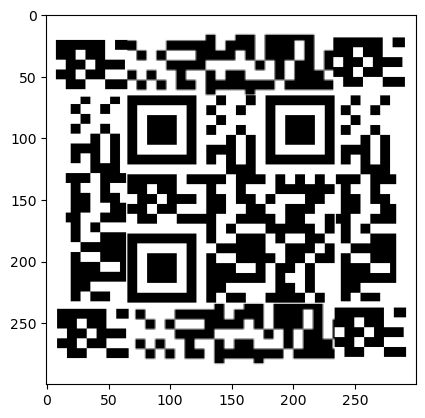

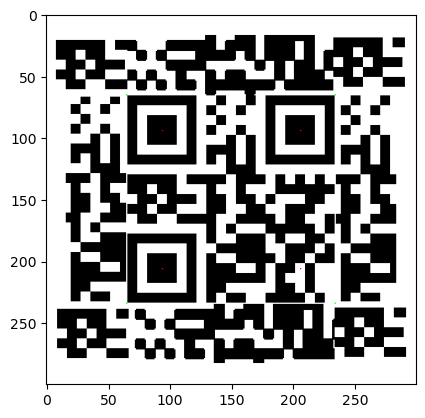

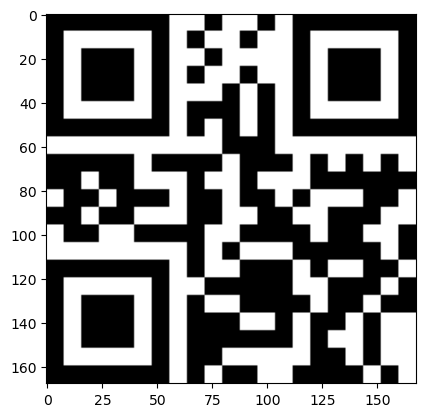

http://byu.edu


In [7]:
image = cv2.imread("QR_codes/challenge1.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(image,cmap="gray");plt.show()
dArray = getArray("QR_codes/challenge1.png", True)
output = decode(dArray)
print(output)

image = cv2.imread("QR_codes/challenge3.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(image,cmap="gray");plt.show()
dArray = getArray("QR_codes/challenge3.png", True)
output = decode(dArray)
print(output)


## Write-up:
Provide an explanation for the following items:
* Which part of this lab did you find most difficult?
* For each challenge completed, explain how you were able to solve the problem presented.
* What improvements would you recommend for this lab?


Your Write-up Here
The part of this lab I found most difficult for this lab was finding the outer corners for the four points. I was able to get the center of the initial 3 points and from here the 4th point fairly quickly but to then move these points outwards from there was a question the was on my mind for over a week. I eventually landed on a solution that I believe was pretty clever but not perfect. I would find the direction to the corner by using the point opposite. from here I knew the point would be a bit more than 3.5 * the horizontal scale in that direction. Using this method I was able to consistently get an outer corner point that would work on all the QR codes, but getting there took a lot of thought, and testing. The first challenge I completed was challenge 3 which worked with zero changes to my previous code, because I was able to find the outer corners which I then set to the edge of the image in the homography, this meant that all the outside interference was just cropped out of the final image. The next challenge I did was challenge 1 which required a bit of refactoring to the order I found and passed my 4 homography points. To get it working, knowing the center point of the three was not going to be enough, I also needed to now roughly the order of the other 2 points with respect to the center. Essentially which point was on the left and which was on the right. To do this I just determined which point was further left by comparing the x vales of the remaining 2 points to that which I found to be the center. This method is far from perfect though, as it doesn't work depending on how far an image is rotated and in what direction. If I were to improve it and make it more robust I was thinking I could have implemented a while loop that would rotate the 3 points around the center till one was roughly to the right and one to the left, at which case I would have a slower but more robust way of finding the orientation of the points. All in all I don't think there is much to improve on this lab. There could maybe be a bit more detail on how to do part A, but I wouldn't say give 2 much because I found the problem solving for that part to be very rewarding. Some linked resources on how to do a barcode could also be useful as that challenge seemed completely unapproachable to me.